In [1]:
import sys
sys.path.append("../preprocessing")

import os
from os.path import join, exists
import glob
import numpy as np
import pandas as pd
import pickle
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from mne.stats import permutation_t_test
from avalanche import fit_powerlaw, fit_third_exponent, dcc

In [2]:
FEATURE_NAME = "Avalanche"
FEATURES_PATH = "../data/avalanche/"
SUBJECTS_PATH = "../data/CAF_200_Inventaire.csv"
STAGES = ["AWSL", "NREM", "REM"]

In [3]:
subj_info = pd.read_csv(SUBJECTS_PATH, index_col=0)

In [4]:
def process_file(path):
    subj = path.split(os.sep)[-3]
    curr = np.load(path, allow_pickle=True)
    cond = "CAF" if subj_info[subj_info["Subject_id"] == subj]["CAF"].values[0] == "Y" else "PLAC"

    # avalanche size
    sizes = np.array([av["size"] for av in curr])
    sizes_powerlaw = fit_powerlaw(sizes)
    # avalanche duration
    durations = np.array([av["dur_bin"] for av in curr])
    durations_powerlaw = fit_powerlaw(durations)
    # fit third exponent
    third_exp = fit_third_exponent(sizes, durations)
    return cond, sizes_powerlaw, durations_powerlaw, third_exp

avl_path = join(FEATURES_PATH, "avalanche.pkl")
if exists(avl_path):
    # load precomputed powerlaws
    with open(avl_path, "rb") as f:
        data = pickle.load(f)
else:
    # recompute powerlaws
    data = {}
    for stage in tqdm(STAGES, position=0, desc="sleep stage"):
        data[stage] = {"CAF": {"size": [], "dur": [], "third": []}, "PLAC": {"size": [], "dur": [], "third": []}}
        result = Parallel(n_jobs=-1)(
            delayed(process_file)(path)
            for path in
            tqdm(glob.glob(join(FEATURES_PATH, "*", FEATURE_NAME, f"*_{stage}.npy")), position=1, desc="file")
        )

        for cond, size, dur, third in result:
            data[stage][cond]["size"].append(size)
            data[stage][cond]["dur"].append(dur)
            data[stage][cond]["third"].append(third)

    with open(avl_path, "wb") as f:
        pickle.dump(data, f)

In [5]:
for stage in STAGES:
    for cond in ["CAF", "PLAC"]:
        probs = np.array([[prob[0] for prob in avl[-5:]] for avl in data[stage][cond]["size"]]).mean(axis=0)
        print(stage, cond, probs)

AWSL CAF [ -4.87357453  -2.81919054 -25.51876047   5.19724034  15.80396848]
AWSL PLAC [ -3.81786385  -2.44145944 -17.31432856   3.48981706  10.58143929]
NREM CAF [-19.5756789   -5.15896576 -44.73288728   6.27738647  31.75982072]
NREM PLAC [-22.81945507  -5.53171848 -44.72330385   5.05213212  30.6420991 ]
REM CAF [-12.50077669  -2.97936956 -30.576594     4.00713827  20.52870235]
REM PLAC [-13.43888282  -2.93546044 -31.01280808   4.07537332  20.87281151]


In [6]:
def get_df(avls):
    df = pd.DataFrame(columns=range(len(avls)))
    for col in range(len(avls)):
        idx = avls[col][1][1:]
        for i, bin_idx in enumerate(idx):
            df.loc[bin_idx, col] = avls[col][0][i]
    return df

def plot_powerlaws(data, var):
    plt.figure(figsize=(15, len(STAGES) * 4))
    plt.suptitle("avalanche " + var, fontsize=25, y=0.97)

    for i, stage in enumerate(STAGES):
        plt.subplot(len(STAGES), 1, i + 1)
        
        df_caf = get_df(data[stage]["CAF"][var])
        df_plac = get_df(data[stage]["PLAC"][var])
        
        mean_caf = df_caf.mean(axis=1)
        std_caf = df_caf.std(axis=1).fillna(0)
        mean_plac = df_plac.mean(axis=1)
        std_plac = df_plac.std(axis=1).fillna(0)

        plt.title(stage, fontsize=14)

        mean_caf.plot()
        plt.fill_between(mean_caf.index, mean_caf - std_caf, mean_caf + std_caf, alpha=0.15)

        mean_plac.plot()
        plt.fill_between(mean_plac.index, mean_plac - std_plac, mean_plac + std_plac, alpha=0.15)

        plt.legend(["CAF", "PLAC"])
        plt.loglog()
    plt.show()

def compare_sleep_stages(data, var):
    plt.figure(figsize=(15, 4))
    for stage in STAGES:
        df_caf = get_df(data[stage]["CAF"][var])
        df_plac = get_df(data[stage]["PLAC"][var])

        plt.plot((df_caf.mean(axis=1) + df_plac.mean(axis=1)) / 2, label=stage)
    plt.legend()
    plt.loglog()
    plt.show()

# Avalanche Size

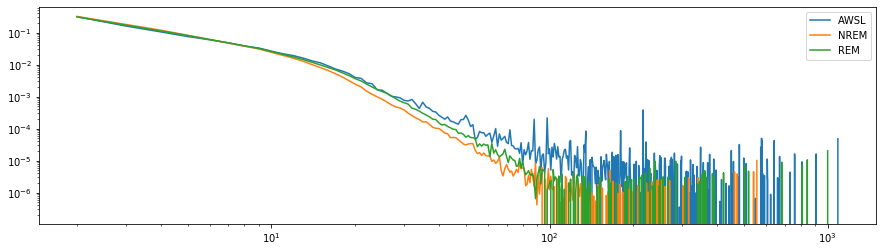

In [7]:
compare_sleep_stages(data, "size")

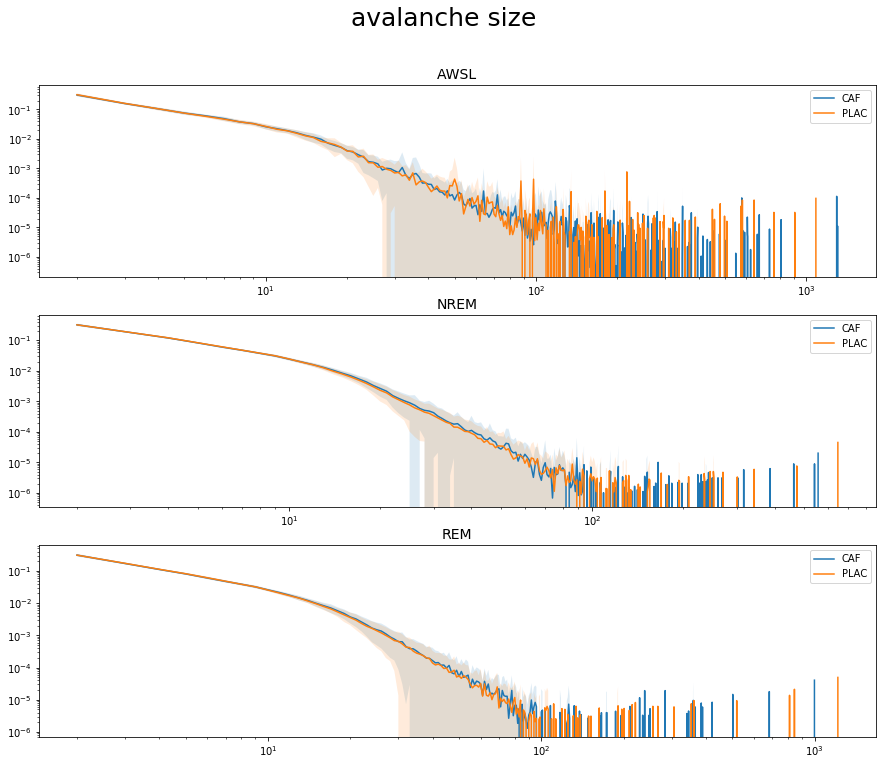

In [8]:
plot_powerlaws(data, "size")

# Avalanche Duration

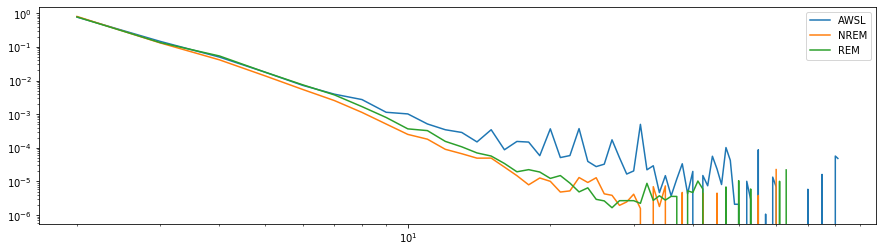

In [9]:
compare_sleep_stages(data, "dur")

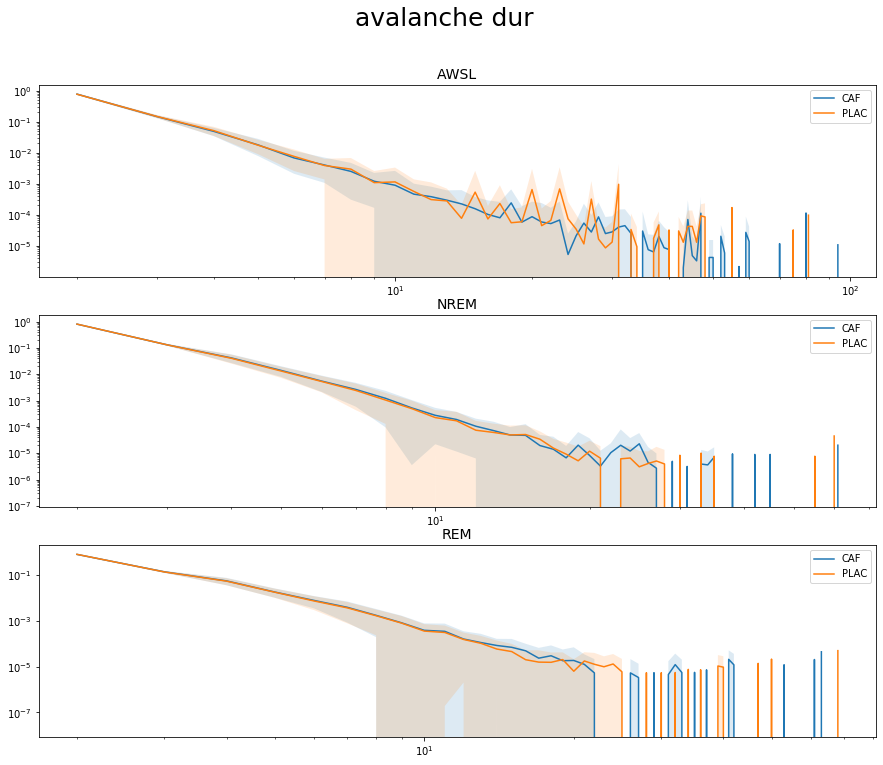

In [10]:
plot_powerlaws(data, "dur")

# Deviation from Criticality Coefficient (DCC)

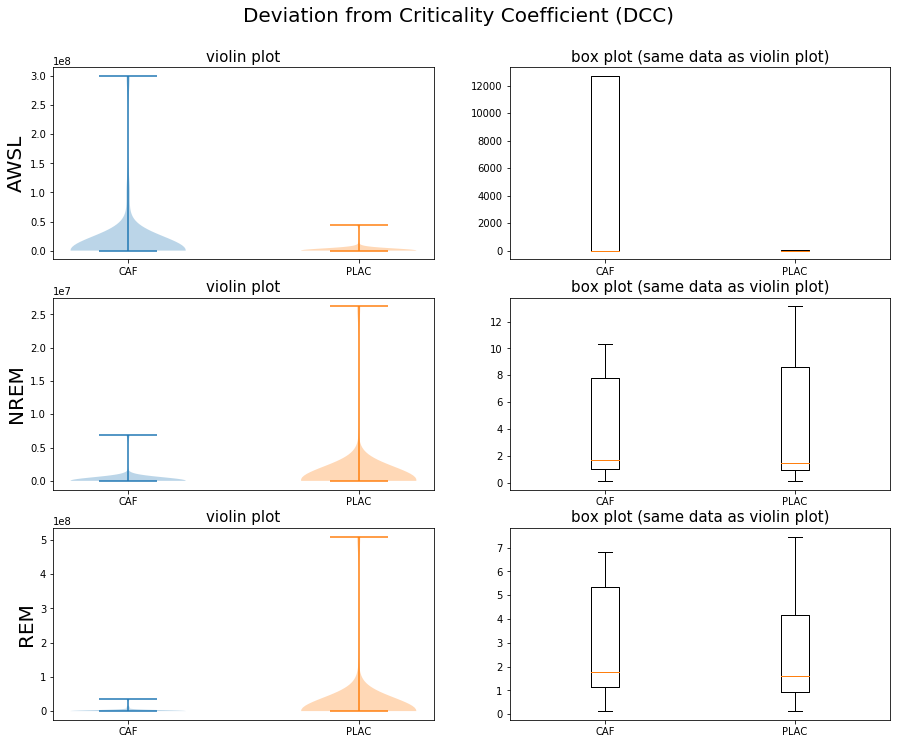

In [11]:
def get_exp(avls):
    return np.array([avl[6] for avl in avls])

def get_dcc(data):
    tau = get_exp(data["size"])
    alpha = get_exp(data["dur"])
    third = np.array(data["third"])
    return np.array([dcc(ta, al, th) for ta, al, th in zip(tau, alpha, third)])

plt.figure(figsize=(15, len(STAGES) * 4))
plt.suptitle("Deviation from Criticality Coefficient (DCC)", fontsize=20, y=0.95)
for i, stage in enumerate(STAGES):
    plt.subplot(len(STAGES), 2, i * 2 + 1)
    plt.title("violin plot", fontsize=15)
    plt.ylabel(stage, fontsize=20)
    plt.violinplot(get_dcc(data[stage]["CAF"]), positions=[0])
    plt.violinplot(get_dcc(data[stage]["PLAC"]), positions=[1])
    plt.xticks([0, 1], ["CAF", "PLAC"])

    plt.subplot(len(STAGES), 2, i * 2 + 2)
    plt.title("box plot (same data as violin plot)", fontsize=15)
    plt.boxplot(get_dcc(data[stage]["CAF"]), positions=[0], labels=["CAF"], showfliers=False)
    plt.boxplot(get_dcc(data[stage]["PLAC"]), positions=[1], labels=["PLAC"], showfliers=False)
plt.show()